In [2]:
import pandas as pd
import pandas_datareader.data as web
import sklearn.mixture as mix

import numpy as np
import scipy.stats as scs

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline

import seaborn as sns
import missingno as msno
from tqdm import tqdm
p=print

In [8]:
start = pd.to_datetime('2010-01-01')
end = pd.to_datetime('2020-12-31')

# get fed data

f1 = pd.read_csv('TEDRATE.csv') # ted spread
f2 = pd.read_csv('T10Y2Y.csv') # constant maturity ten yer - 2 year
f3 = pd.read_csv('T10Y3M.csv') # constant maturity 10yr - 3m

# get market data
nflx = pd.read_csv('NFLX.csv')
vz = pd.read_csv('VZ.csv')
ibm = pd.read_csv('IBM.csv')


# MKT = (web.DataReader([mkt], 'yahoo', start, end)['Close']
#        .rename(columns={mkt:mkt})
#        .assign(sret=lambda x: np.log(x[mkt]/x[mkt].shift(1)))
#        .dropna())

# data = (web.DataReader([f1, f2, f3], 'fred', start, end)
#         .join(MKT, how='inner')
#         .dropna()
#        )

# p(data.head())

# # gives us a quick visual inspection of the data
# msno.matrix(data)
df = {'DATE':f1['DATE'],'TEDRATE':f1['TEDRATE'],'T10Y2Y':f2['T10Y2Y'],'T10Y3M':f3['T10Y3M'],'NFLX':nflx['Close'],'VZ':vz['Close'],'IBM':ibm['Close']}
df = pd.DataFrame(df)
df.index = df['DATE'].astype('datetime64[ns]')
df = df.drop(columns='DATE').dropna()
df

,TEDRATE,T10Y2Y,T10Y3M,NFLX,VZ,IBM
DATE,,,,,,
2010-01-04,0.17,2.76,3.77,7.640000,31.212946,132.449997
2010-01-05,0.18,2.76,3.70,7.358571,31.269218,130.850006
2010-01-06,0.19,2.84,3.79,7.617143,29.937416,130.000000
2010-01-07,0.20,2.82,3.80,7.485714,29.759218,129.550003
2010-01-08,0.20,2.87,3.78,7.614286,29.777975,130.850006
...,...,...,...,...,...,...
2020-08-06,0.14,0.44,0.45,514.479980,58.959999,123.900002
2020-08-07,0.15,0.44,0.47,513.969971,58.840000,124.690002
2020-08-10,0.15,0.45,0.48,519.119995,58.980000,124.820000


In [9]:
df['NFLX-LogReturn'] = np.log(df.loc[:, 'NFLX'] / df.loc[:, 'NFLX'].shift(1))
df['VZ-LogReturn'] = np.log(df.loc[:, 'VZ'] / df.loc[:, 'VZ'].shift(1))
df['IBM-LogReturn'] = np.log(df.loc[:, 'IBM'] / df.loc[:, 'IBM'].shift(1))
df = df.dropna()
df = df[df['TEDRATE']!='.']
df = df[df['T10Y2Y']!='.']
df = df[df['T10Y3M']!='.']
df = df.astype(float)
df

,TEDRATE,T10Y2Y,T10Y3M,NFLX,VZ,IBM,NFLX-LogReturn,VZ-LogReturn,IBM-LogReturn
DATE,,,,,,,,,
2010-01-05,0.18,2.76,3.70,7.358571,31.269218,130.850006,-0.037532,0.001801,-0.012154
2010-01-06,0.19,2.84,3.79,7.617143,29.937416,130.000000,0.034536,-0.043525,-0.006517
2010-01-07,0.20,2.82,3.80,7.485714,29.759218,129.550003,-0.017405,-0.005970,-0.003468
2010-01-08,0.20,2.87,3.78,7.614286,29.777975,130.850006,0.017030,0.000630,0.009985
2010-01-11,0.21,2.90,3.81,7.604286,29.899900,129.479996,-0.001314,0.004086,-0.010525
...,...,...,...,...,...,...,...,...,...
2020-08-06,0.14,0.44,0.45,514.479980,58.959999,123.900002,-0.024670,-0.000509,0.002343
2020-08-07,0.15,0.44,0.47,513.969971,58.840000,124.690002,-0.000992,-0.002037,0.006356
2020-08-10,0.15,0.45,0.48,519.119995,58.980000,124.820000,0.009970,0.002377,0.001042


NFLX

In [149]:
df_1 = df[df.index>='2018-03-01']
df_1 = df_1[df_1.index<='2019-08-01']

In [150]:
ft_cols = ['TEDRATE', 'T10Y2Y', 'T10Y3M', 'NFLX-LogReturn']
X = df_1[ft_cols].values

model = mix.GaussianMixture(n_components=3, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(X)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covariances_[i]))
    print()

Means and vars of each hidden state
0th hidden state
mean =  [ 0.38939497  0.16510442  0.32490958 -0.00238881]
var =  [0.00255902 0.0005306  0.00924534 0.00059603]

1th hidden state
mean =  [ 0.3778888   0.35804903  0.93472623 -0.00096508]
var =  [0.01557382 0.01407509 0.02044086 0.00085876]

2th hidden state
mean =  [ 0.20472064  0.20162485  0.00642704 -0.000503  ]
var =  [0.00097831 0.00192776 0.01840489 0.00038906]



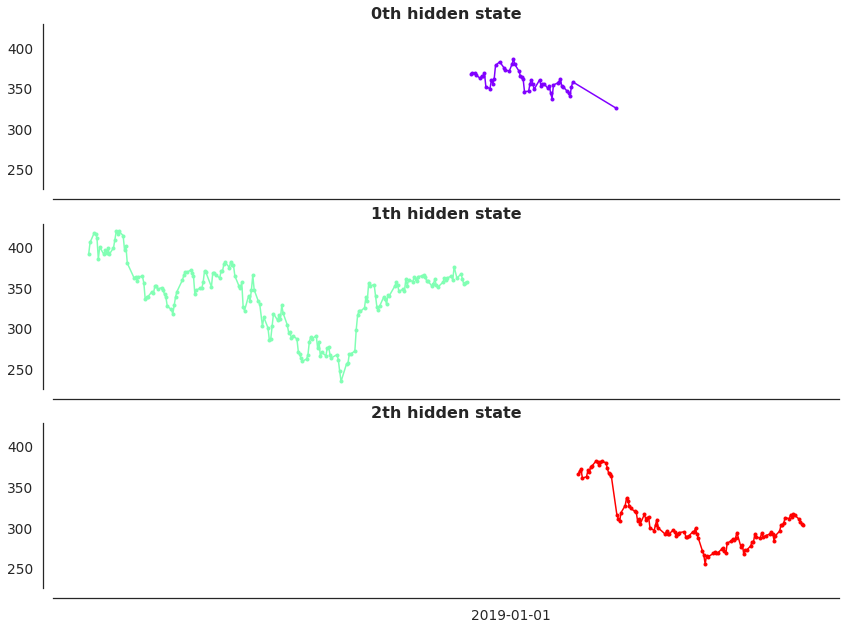

In [151]:
sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':u'courier prime code', 'legend.frameon': True}
sns.set_style('white', style_kwds)

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(df_1.index.values[mask],
                 df_1['NFLX'].values[mask],
                 ".-", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)

plt.tight_layout()
# fig.savefig('Hidden Markov (Mixture) Model_Regime Subplots.png')

In [152]:
states = (pd.DataFrame(hidden_states, columns=['states'], index=df_1.index)
          .join(df_1, how='inner')
          .assign(mkt_cret=df_1['NFLX-LogReturn'].cumsum())
         .reset_index(drop=False))
states

,DATE,states,TEDRATE,T10Y2Y,T10Y3M,NFLX,VZ,IBM,NFLX-LogReturn,VZ-LogReturn,IBM-LogReturn,mkt_cret
0,2018-03-01,1,0.42,0.59,1.18,390.399994,47.459999,144.479996,-0.004039,-0.012563,-0.006279,-0.004039
1,2018-03-02,1,0.41,0.61,1.21,404.980011,48.500000,143.899994,0.036666,0.021677,-0.004022,0.032627
2,2018-03-05,1,0.36,0.64,1.18,416.760010,48.090000,142.630005,0.028673,-0.008490,-0.008865,0.061300
3,2018-03-06,1,0.40,0.63,1.20,415.440002,48.630001,141.250000,-0.003172,0.011166,-0.009723,0.058127
4,2018-03-07,1,0.41,0.64,1.21,411.089996,49.759998,141.279999,-0.010526,0.022971,0.000212,0.047601
...,...,...,...,...,...,...,...,...,...,...,...,...
345,2019-07-26,2,0.19,0.22,-0.04,314.660004,60.240002,134.449997,-0.004028,0.002327,0.005070,-0.320675
346,2019-07-29,2,0.19,0.21,-0.06,309.989990,59.959999,132.910004,-0.014953,-0.004659,-0.011520,-0.335628
347,2019-07-30,2,0.21,0.21,-0.02,306.160004,60.139999,132.119995,-0.012432,0.002998,-0.005962,-0.348060
348,2019-07-31,2,0.23,0.13,-0.06,304.320007,60.529999,131.990005,-0.006028,0.006464,-0.000984,-0.354088


/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


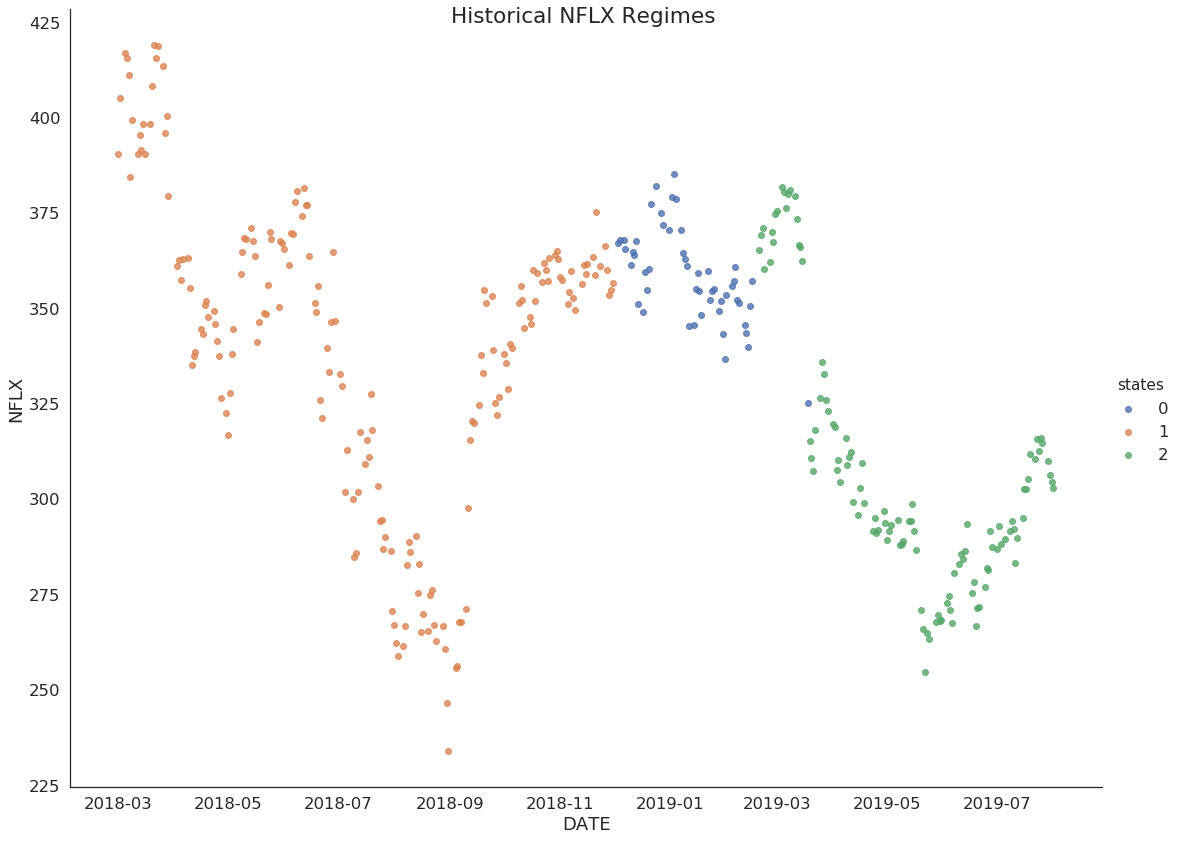

In [153]:
sns.set(font_scale=1.5)
sns.set_style('white', style_kwds)
order = [0, 1, 2]  # High, Neutral and Low Volatility
fg = sns.FacetGrid(data=states, hue='states', hue_order=order, aspect=1.31, size=12)
fg.map(plt.scatter, 'DATE','NFLX', alpha=0.8).add_legend()
# sns.despine(offset=10)
fg.fig.suptitle('Historical NFLX Regimes')
fg.savefig('Hidden Markov (Mixture) Model_NFLX Regimes.png')

In [154]:
# Implement Strategy - sell stock at high regime, buy stock at low regime
hmm = []
dummy_hold = []

class Me:
    def __init__(self):
        self.stock_share = 0.0
        self.cash = 100.0
    
    def buy(self, price):
        if self.cash > 0:
            self.stock_share += self.cash/price
            self.cash = 0

    def sell(self, price):
        self.cash += self.stock_share * price
        self.stock_share = 0

    def hold(self):
        pass

    def portfolio(self, price):
        return self.cash + self.stock_share * price

me = Me()

for index, row in states[0:].iterrows():
    if row['states'] == 0:
        me.hold()
    elif row['states'] == 2:
        me.buy(row['NFLX'])
    elif row['states'] == 1:
        me.sell(row['NFLX'])
    else:
        raise Exception("state not in 0,1,2")
    hmm.append(me.portfolio(row['NFLX']))

dummy = Me()

for index, row in states[0:].iterrows():
    dummy.buy(row['NFLX'])
    dummy_hold.append(dummy.portfolio(row['NFLX']))
        

hmm = np.array(hmm)
dummy_hold = np.array(dummy_hold)
states['NFLX - By HMM'] = hmm
states['NFLX - By Buy&Hold'] = dummy_hold
states

,DATE,states,TEDRATE,T10Y2Y,T10Y3M,NFLX,VZ,IBM,NFLX-LogReturn,VZ-LogReturn,IBM-LogReturn,mkt_cret,NFLX - By HMM,NFLX - By Buy&Hold
0,2018-03-01,1,0.42,0.59,1.18,390.399994,47.459999,144.479996,-0.004039,-0.012563,-0.006279,-0.004039,100.000000,100.000000
1,2018-03-02,1,0.41,0.61,1.21,404.980011,48.500000,143.899994,0.036666,0.021677,-0.004022,0.032627,100.000000,103.734636
2,2018-03-05,1,0.36,0.64,1.18,416.760010,48.090000,142.630005,0.028673,-0.008490,-0.008865,0.061300,100.000000,106.752053
3,2018-03-06,1,0.40,0.63,1.20,415.440002,48.630001,141.250000,-0.003172,0.011166,-0.009723,0.058127,100.000000,106.413937
4,2018-03-07,1,0.41,0.64,1.21,411.089996,49.759998,141.279999,-0.010526,0.022971,0.000212,0.047601,100.000000,105.299693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,2019-07-26,2,0.19,0.22,-0.04,314.660004,60.240002,134.449997,-0.004028,0.002327,0.005070,-0.320675,86.158652,80.599388
346,2019-07-29,2,0.19,0.21,-0.06,309.989990,59.959999,132.910004,-0.014953,-0.004659,-0.011520,-0.335628,84.879931,79.403175
347,2019-07-30,2,0.21,0.21,-0.02,306.160004,60.139999,132.119995,-0.012432,0.002998,-0.005962,-0.348060,83.831224,78.422133
348,2019-07-31,2,0.23,0.13,-0.06,304.320007,60.529999,131.990005,-0.006028,0.006464,-0.000984,-0.354088,83.327405,77.950823


(array([736754., 736815., 736876., 736938., 736999., 737060., 737119.,
        737180., 737241.]),
 <a list of 9 Text xticklabel objects>)

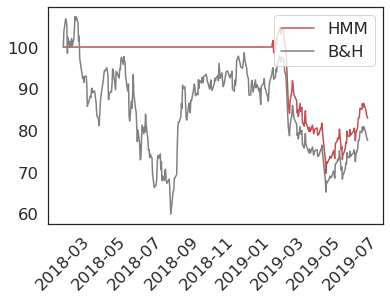

In [155]:
plt.plot(states['DATE'],states['NFLX - By HMM'], color = 'r')
plt.plot(states['DATE'],states['NFLX - By Buy&Hold'], color = 'grey')
plt.legend(('HMM', 'B&H'), loc='upper right', shadow=False)
plt.xticks(rotation=45)

In [123]:
states['DATE'].dt.year

0      2018
1      2018
2      2018
3      2018
4      2018
       ... 
345    2019
346    2019
347    2019
348    2019
349    2019
Name: DATE, Length: 350, dtype: int64

VZ

In [124]:
df_2 = df[df.index>='2018-12-01']
df_2 = df_2[df_2.index<='2019-11-01']

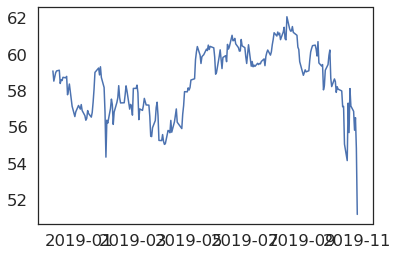

In [125]:
plt.plot(df_2['VZ'])

In [126]:
ft_cols = ['TEDRATE', 'T10Y2Y', 'T10Y3M', 'VZ-LogReturn']
X = df_2[ft_cols].values

model = mix.GaussianMixture(n_components=3, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(X)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covariances_[i]))
    print()

Means and vars of each hidden state
0th hidden state
mean =  [ 0.37925284  0.16805516  0.287646   -0.00219641]
var =  [0.00257277 0.00049641 0.01377589 0.00033531]

1th hidden state
mean =  [ 0.23515001  0.08096848 -0.24255004 -0.00151801]
var =  [3.34802376e-03 3.45185128e-03 2.09549483e-02 8.81891713e-05]

2th hidden state
mean =  [0.20600282 0.20506591 0.01979353 0.00067959]
var =  [8.49293674e-04 1.89707423e-03 1.77485873e-02 6.80836158e-05]



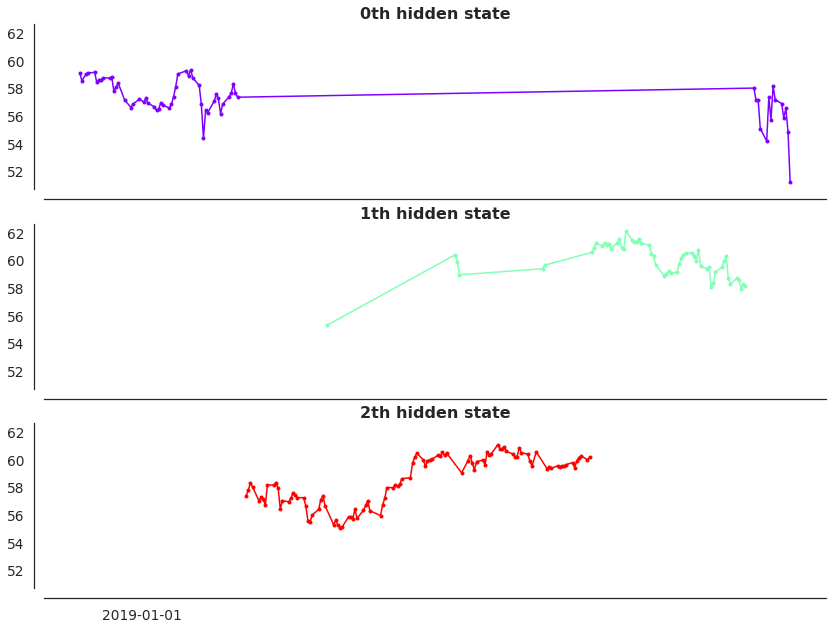

In [127]:
sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':u'courier prime code', 'legend.frameon': True}
sns.set_style('white', style_kwds)

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(df_2.index.values[mask],
                 df_2['VZ'].values[mask],
                 ".-", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)

plt.tight_layout()
# fig.savefig('Hidden Markov (Mixture) Model_Regime Subplots.png')

In [128]:
states = (pd.DataFrame(hidden_states, columns=['states'], index=df_2.index)
          .join(df, how='inner')
          .assign(mkt_cret=df_2['VZ-LogReturn'].cumsum())
         .reset_index(drop=False))
states

,DATE,states,TEDRATE,T10Y2Y,T10Y3M,NFLX,VZ,IBM,NFLX-LogReturn,VZ-LogReturn,IBM-LogReturn,mkt_cret
0,2018-12-03,0,0.41,0.15,0.60,366.959991,59.090000,143.300003,0.028750,-0.000677,0.015471,-0.000677
1,2018-12-04,0,0.36,0.11,0.49,367.720001,58.529999,143.000000,0.002069,-0.009522,-0.002096,-0.010199
2,2018-12-06,0,0.41,0.12,0.46,367.880005,58.990002,142.779999,-0.005070,0.002036,-0.005936,-0.008163
3,2018-12-07,0,0.42,0.13,0.45,365.489990,59.090000,143.279999,-0.006518,0.001694,0.003496,-0.006469
4,2018-12-10,0,0.41,0.13,0.44,361.410004,59.130001,143.389999,-0.011226,0.000677,0.000767,-0.005792
...,...,...,...,...,...,...,...,...,...,...,...,...
221,2019-10-28,0,0.32,0.21,0.20,368.970001,56.869999,127.730003,-0.010273,-0.005086,-0.014148,-0.055518
222,2019-10-29,0,0.33,0.20,0.21,346.489990,55.830002,117.809998,-0.062861,-0.018457,-0.080846,-0.073975
223,2019-10-30,0,0.32,0.17,0.16,364.130005,56.520000,124.769997,0.049657,0.012283,0.057399,-0.061691
224,2019-10-31,0,0.39,0.17,0.15,349.920013,54.830002,117.970001,-0.039806,-0.030357,-0.056042,-0.092048


/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 0.98, 'Historical VZ Regimes')

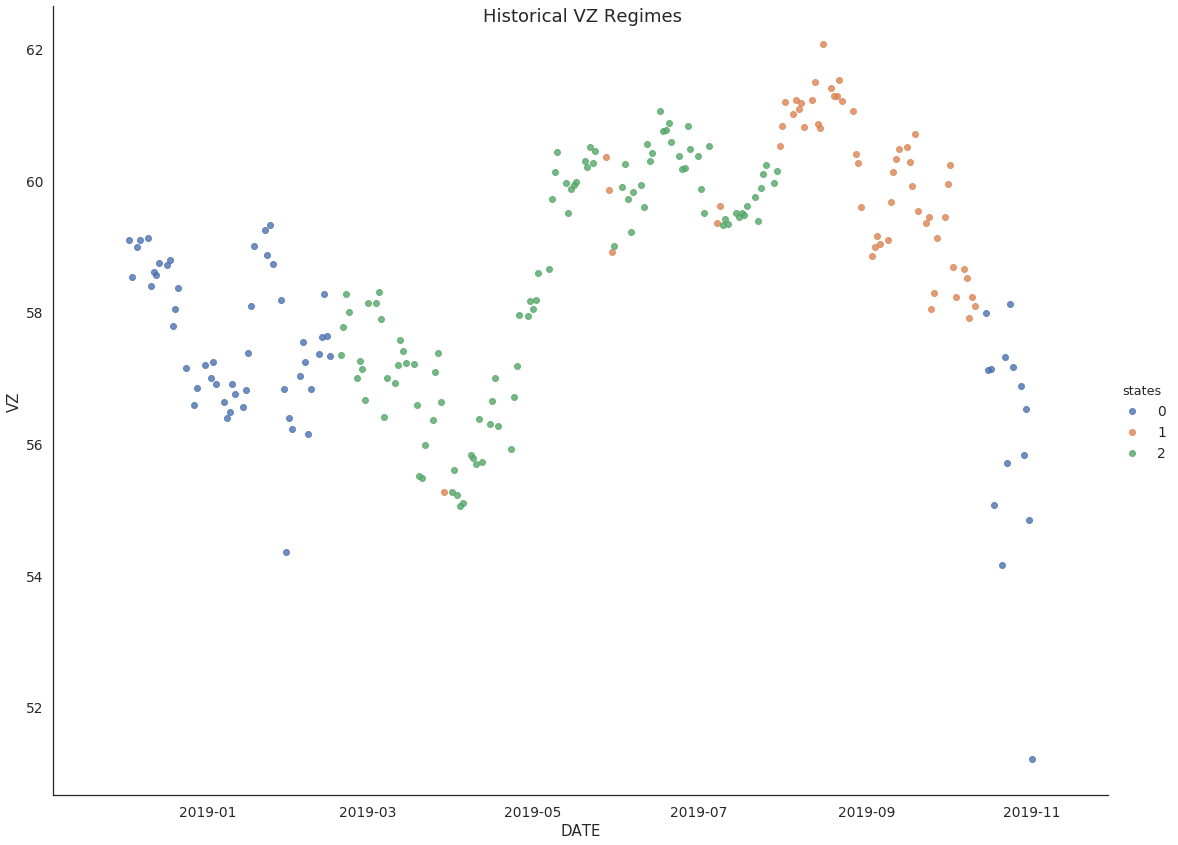

In [129]:
# sns.set(font_scale=1.5)
# sns.set_style('white', style_kwds)
order = [0, 1, 2]
fg = sns.FacetGrid(data=states, hue='states', hue_order=order, aspect=1.31, size=12)
fg.map(plt.scatter, 'DATE','VZ', alpha=0.8).add_legend()
# sns.despine(offset=10)
fg.fig.suptitle('Historical VZ Regimes')
# fg.savefig('Hidden Markov (Mixture) Model_RUT Regimes.png')

In [130]:
# Implement Strategy - sell stock at high regime, buy stock at low regime
hmm = []
dummy_hold = []

class Me:
    def __init__(self):
        self.stock_share = 0.0
        self.cash = 100.0
    
    def buy(self, price):
        if self.cash > 0:
            self.stock_share += self.cash/price
            self.cash = 0

    def sell(self, price):
        self.cash += self.stock_share * price
        self.stock_share = 0

    def hold(self):
        pass

    def portfolio(self, price):
        return self.cash + self.stock_share * price

me = Me()

for index, row in states[0:].iterrows():
    if row['states'] == 1:
        me.hold()
    elif row['states'] == 2:
        me.buy(row['VZ'])
    elif row['states'] == 0:
        me.sell(row['VZ'])
    else:
        raise Exception("state not in 0,1,2")
    hmm.append(me.portfolio(row['VZ']))

dummy = Me()

for index, row in states[0:].iterrows():
    dummy.buy(row['VZ'])
    dummy_hold.append(dummy.portfolio(row['VZ']))
        

hmm = np.array(hmm)
dummy_hold = np.array(dummy_hold)
states['VZ - By HMM'] = hmm
states['VZ - By Buy&Hold'] = dummy_hold
states

,DATE,states,TEDRATE,T10Y2Y,T10Y3M,NFLX,VZ,IBM,NFLX-LogReturn,VZ-LogReturn,IBM-LogReturn,mkt_cret,VZ - By HMM,VZ - By Buy&Hold
0,2018-12-03,0,0.41,0.15,0.60,366.959991,59.090000,143.300003,0.028750,-0.000677,0.015471,-0.000677,100.000000,100.000000
1,2018-12-04,0,0.36,0.11,0.49,367.720001,58.529999,143.000000,0.002069,-0.009522,-0.002096,-0.010199,100.000000,99.052291
2,2018-12-06,0,0.41,0.12,0.46,367.880005,58.990002,142.779999,-0.005070,0.002036,-0.005936,-0.008163,100.000000,99.830770
3,2018-12-07,0,0.42,0.13,0.45,365.489990,59.090000,143.279999,-0.006518,0.001694,0.003496,-0.006469,100.000000,100.000000
4,2018-12-10,0,0.41,0.13,0.44,361.410004,59.130001,143.389999,-0.011226,0.000677,0.000767,-0.005792,100.000000,100.067695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,2019-10-28,0,0.32,0.21,0.20,368.970001,56.869999,127.730003,-0.010273,-0.005086,-0.014148,-0.055518,101.133593,96.243017
222,2019-10-29,0,0.33,0.20,0.21,346.489990,55.830002,117.809998,-0.062861,-0.018457,-0.080846,-0.073975,101.133593,94.482995
223,2019-10-30,0,0.32,0.17,0.16,364.130005,56.520000,124.769997,0.049657,0.012283,0.057399,-0.061691,101.133593,95.650702
224,2019-10-31,0,0.39,0.17,0.15,349.920013,54.830002,117.970001,-0.039806,-0.030357,-0.056042,-0.092048,101.133593,92.790662


(array([737060., 737119., 737180., 737241., 737303., 737364.]),
 <a list of 6 Text xticklabel objects>)

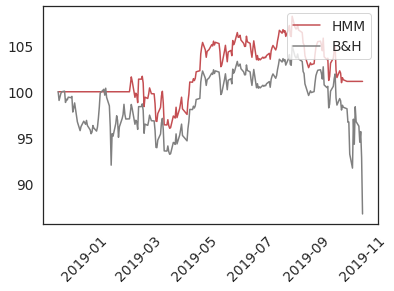

In [131]:
plt.plot(states['DATE'],states['VZ - By HMM'], color = 'r')
plt.plot(states['DATE'],states['VZ - By Buy&Hold'], color = 'grey')
plt.legend(('HMM', 'B&H'), loc='upper right', shadow=False)
plt.xticks(rotation=45)

IBM

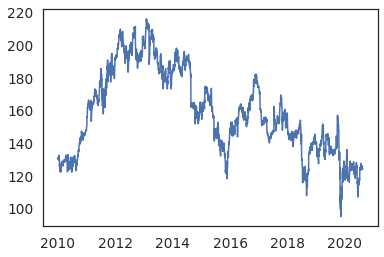

In [132]:
plt.plot(df['IBM'])

In [133]:
df_3 = df[df.index>='2016-11-01']
df_3 = df_3[df_3.index<='2017-07-01']

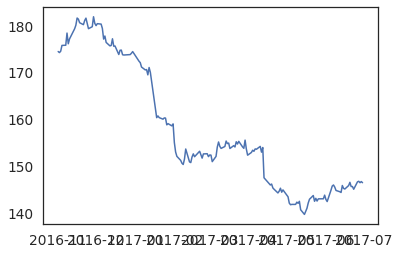

In [134]:
plt.plot(df_3['IBM'])

In [135]:
df_3

,TEDRATE,T10Y2Y,T10Y3M,NFLX,VZ,IBM,NFLX-LogReturn,VZ-LogReturn,IBM-LogReturn
DATE,,,,,,,,,
2016-11-01,0.53,1.00,1.48,140.710007,49.009998,174.520004,-0.003618,-0.007319,-0.007308
2016-11-02,0.52,1.00,1.44,140.779999,48.389999,174.289993,0.000497,-0.012731,-0.001319
2016-11-03,0.51,1.01,1.44,139.199997,48.279999,174.580002,-0.011287,-0.002276,0.001663
2016-11-04,0.51,0.99,1.41,140.250000,48.580002,175.820007,0.007515,0.006195,0.007078
2016-11-07,0.48,1.01,1.42,140.970001,48.029999,175.860001,0.005121,-0.011386,0.000227
...,...,...,...,...,...,...,...,...,...
2017-06-26,0.31,0.78,1.15,177.009995,49.360001,146.660004,-0.024223,-0.002630,0.010832
2017-06-27,0.31,0.83,1.21,179.190002,49.849998,146.779999,0.012241,0.009878,0.000818
2017-06-28,0.30,0.88,1.20,184.449997,49.900002,146.479996,0.028932,0.001003,-0.002046


In [136]:
ft_cols = ['TEDRATE', 'T10Y2Y', 'T10Y3M', 'IBM-LogReturn']
X = df_3[ft_cols].values

model = mix.GaussianMixture(n_components=3, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(X)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covariances_[i]))
    print()

Means and vars of each hidden state
0th hidden state
mean =  [0.27908    0.87599718 1.22136681 0.00141654]
var =  [7.26147735e-04 3.58565066e-03 3.97307699e-03 3.27668151e-05]

1th hidden state
mean =  [ 4.76266523e-01  1.23498627e+00  1.88650040e+00 -1.08196111e-03]
var =  [2.49318134e-03 2.40350522e-03 8.56212128e-03 4.59453922e-05]

2th hidden state
mean =  [ 0.37274943  1.06057444  1.50676144 -0.00218774]
var =  [3.88676821e-03 2.54754711e-03 6.31273202e-03 7.87027086e-05]



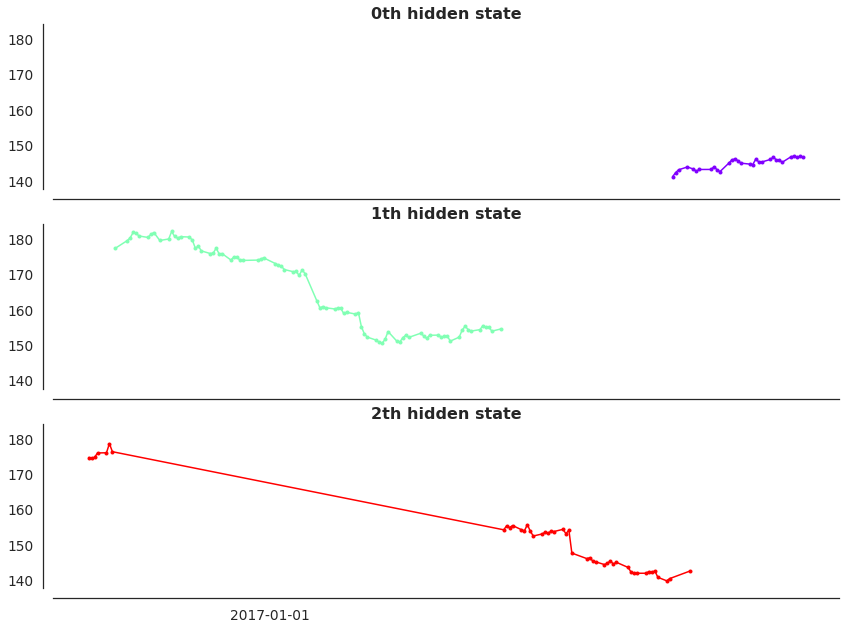

In [137]:
sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':u'courier prime code', 'legend.frameon': True}
sns.set_style('white', style_kwds)

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(df_3.index.values[mask],
                 df_3['IBM'].values[mask],
                 ".-", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)

plt.tight_layout()
fig.savefig('Hidden Markov (Mixture) Model_Regime Subplots.png')

In [140]:
states = (pd.DataFrame(hidden_states, columns=['states'], index=df_3.index)
          .join(df, how='inner')
          .assign(mkt_cret=df['IBM-LogReturn'].cumsum())
         .reset_index(drop=False))
states

,DATE,states,TEDRATE,T10Y2Y,T10Y3M,NFLX,VZ,IBM,NFLX-LogReturn,VZ-LogReturn,IBM-LogReturn,mkt_cret
0,2016-11-01,2,0.53,1.00,1.48,140.710007,49.009998,174.520004,-0.003618,-0.007319,-0.007308,0.277669
1,2016-11-02,2,0.52,1.00,1.44,140.779999,48.389999,174.289993,0.000497,-0.012731,-0.001319,0.276350
2,2016-11-03,2,0.51,1.01,1.44,139.199997,48.279999,174.580002,-0.011287,-0.002276,0.001663,0.278013
3,2016-11-04,2,0.51,0.99,1.41,140.250000,48.580002,175.820007,0.007515,0.006195,0.007078,0.285091
4,2016-11-07,2,0.48,1.01,1.42,140.970001,48.029999,175.860001,0.005121,-0.011386,0.000227,0.285318
...,...,...,...,...,...,...,...,...,...,...,...,...
158,2017-06-26,0,0.31,0.78,1.15,177.009995,49.360001,146.660004,-0.024223,-0.002630,0.010832,0.137530
159,2017-06-27,0,0.31,0.83,1.21,179.190002,49.849998,146.779999,0.012241,0.009878,0.000818,0.138347
160,2017-06-28,0,0.30,0.88,1.20,184.449997,49.900002,146.479996,0.028932,0.001003,-0.002046,0.136301
161,2017-06-29,0,0.28,0.89,1.23,194.389999,49.770000,146.720001,0.052488,-0.002609,0.001637,0.137939


/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


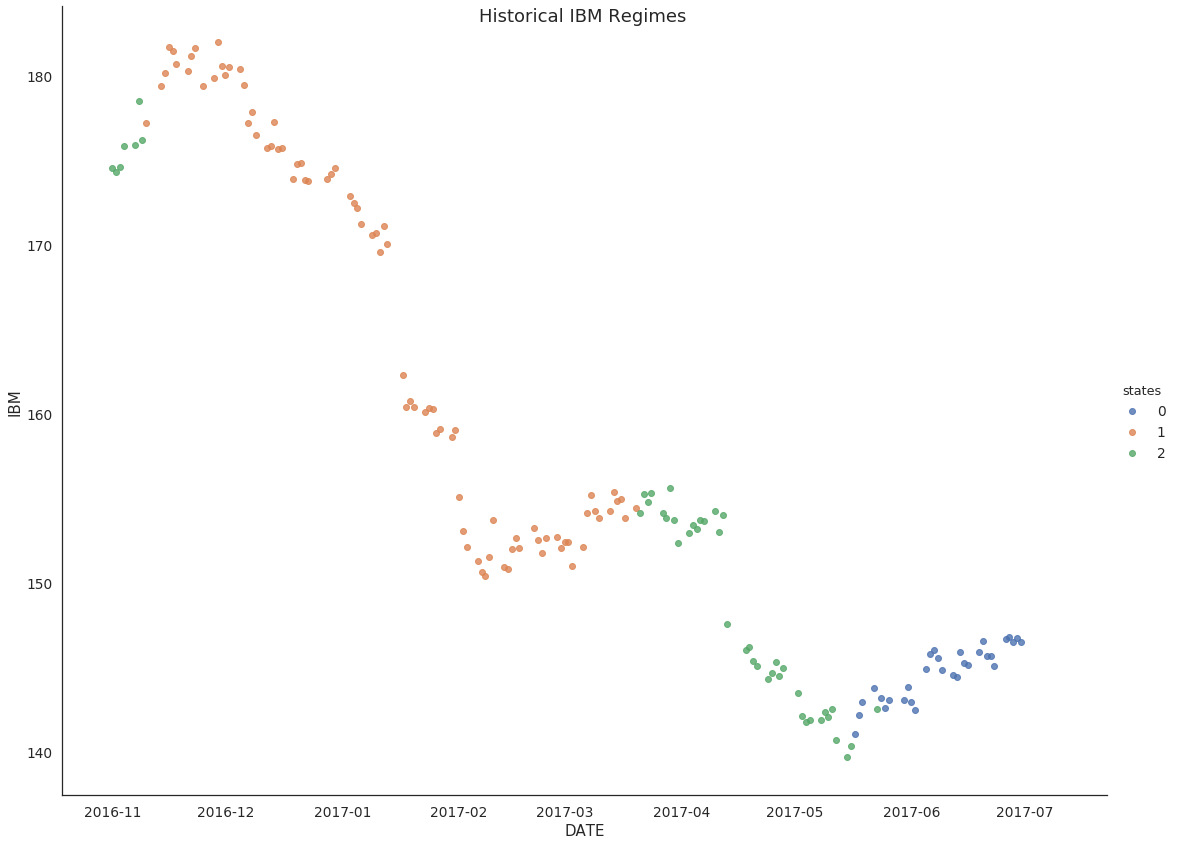

In [141]:
# sns.set(font_scale=1.5)
# sns.set_style('white', style_kwds)
order = [0, 1, 2]
fg = sns.FacetGrid(data=states, hue='states', hue_order=order, aspect=1.31, size=12)
fg.map(plt.scatter, 'DATE','IBM', alpha=0.8).add_legend()
# sns.despine(offset=10)
fg.fig.suptitle('Historical IBM Regimes')
fg.savefig('Hidden Markov (Mixture) Model_AMZN Regimes.png')

In [142]:
# Implement Strategy - sell stock at high regime, buy stock at low regime
hmm = []
dummy_hold = []

class Me:
    def __init__(self):
        self.stock_share = 0.0
        self.cash = 100.0
    
    def buy(self, price):
        if self.cash > 0:
            self.stock_share += self.cash/price
            self.cash = 0

    def sell(self, price):
        self.cash += self.stock_share * price
        self.stock_share = 0

    def hold(self):
        pass

    def portfolio(self, price):
        return self.cash + self.stock_share * price

me = Me()

for index, row in states[0:].iterrows():
    if row['states'] == 1:
        me.hold()
    elif row['states'] == 0:
        me.buy(row['IBM'])
    elif row['states'] == 2:
        me.sell(row['IBM'])
    else:
        raise Exception("state not in 0,1,2")
    hmm.append(me.portfolio(row['IBM']))

dummy = Me()

for index, row in states[0:].iterrows():
    dummy.buy(row['IBM'])
    dummy_hold.append(dummy.portfolio(row['IBM']))
        

hmm = np.array(hmm)
dummy_hold = np.array(dummy_hold)
states['IBM - By HMM'] = hmm
states['IBM - By Buy&Hold'] = dummy_hold
states

,DATE,states,TEDRATE,T10Y2Y,T10Y3M,NFLX,VZ,IBM,NFLX-LogReturn,VZ-LogReturn,IBM-LogReturn,mkt_cret,IBM - By HMM,IBM - By Buy&Hold
0,2016-11-01,2,0.53,1.00,1.48,140.710007,49.009998,174.520004,-0.003618,-0.007319,-0.007308,0.277669,100.000000,100.000000
1,2016-11-02,2,0.52,1.00,1.44,140.779999,48.389999,174.289993,0.000497,-0.012731,-0.001319,0.276350,100.000000,99.868204
2,2016-11-03,2,0.51,1.01,1.44,139.199997,48.279999,174.580002,-0.011287,-0.002276,0.001663,0.278013,100.000000,100.034379
3,2016-11-04,2,0.51,0.99,1.41,140.250000,48.580002,175.820007,0.007515,0.006195,0.007078,0.285091,100.000000,100.744902
4,2016-11-07,2,0.48,1.01,1.42,140.970001,48.029999,175.860001,0.005121,-0.011386,0.000227,0.285318,100.000000,100.767819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,2017-06-26,0,0.31,0.78,1.15,177.009995,49.360001,146.660004,-0.024223,-0.002630,0.010832,0.137530,103.549048,84.036214
159,2017-06-27,0,0.31,0.83,1.21,179.190002,49.849998,146.779999,0.012241,0.009878,0.000818,0.138347,103.633770,84.104971
160,2017-06-28,0,0.30,0.88,1.20,184.449997,49.900002,146.479996,0.028932,0.001003,-0.002046,0.136301,103.421954,83.933069
161,2017-06-29,0,0.28,0.89,1.23,194.389999,49.770000,146.720001,0.052488,-0.002609,0.001637,0.137939,103.591409,84.070592


(array([736269., 736299., 736330., 736361., 736389., 736420., 736450.,
        736481., 736511.]),
 <a list of 9 Text xticklabel objects>)

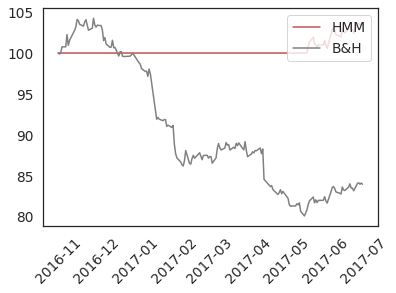

In [143]:
plt.plot(states['DATE'],states['IBM - By HMM'], color = 'r')
plt.plot(states['DATE'],states['IBM - By Buy&Hold'], color = 'grey')
plt.legend(('HMM', 'B&H'), loc='upper right', shadow=False)
plt.xticks(rotation=45)

1. presentation-顺序
2. paper写不写
3. 思路 - bearish time, reduce expected loss
